# Classifying Breast Tumoral Masses as Benign/Malignant 

## This notebook is the result of an iterative process of research and testing aimed at finding the best machine learning  model capable of predicting the malignant nature of breast cancer cells based on its morphological characteristics. Further information can be found on the related prospect.

> Importing the needed modules

In [122]:
import warnings
warnings.filterwarnings('ignore')

In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.pyplot as plt

> Loading the data

In [124]:
import pandas as pd
data = pd.read_csv("merged_dataframe.csv")

# Data preparation

> Imputing binary values to diagnosis (0 = Benign ; 1 = Malignant)

In [125]:
diagnosis_map = {'B': 0, 'M': 1}

In [126]:
data['diagnosis'] = data['diagnosis'].replace(diagnosis_map)

> Splitting the merged dataset in train/test

In [127]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['diagnosis','id'], axis=1),
                                                    data['diagnosis'],
                                                    test_size=0.2,
                                                    stratify=data['diagnosis'],
                                                    random_state=42)

> Scaling the feature sets (X_train, X_test) to apply Logistic Regression

In [128]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [129]:
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)

In [130]:
X_test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

# Modelling the data

> Applying the Logistic Regression model and tuning the hyperparameters

In [131]:
from sklearn.linear_model import LogisticRegression

In [132]:
LR = LogisticRegression(solver='liblinear', max_iter=1000)
parameters = {
    'penalty': ['l2', 'l1'],
    'C': [0.01, 0.1, 1, 10],
}

In [133]:
model = GridSearchCV(
    LR,                       # this is the instantiated estimator object, that is, the model we want to tune
    param_grid=parameters,    # this is the predefined search space
    scoring="recall",         # the metric we want the tuner calculates in order to select the best combination
    cv=5,                     # the cross-validation schema we want to use
    refit=True,               # if we want to fit again the model on the best hyperparameters found after the process
)

In [134]:
model.fit(X_train_sc, y_train)

y_val_proba = model.predict_proba(X_test_sc)[:,1]

In [135]:
print(f"Best parameters: {model.best_params_}")
print(f"Best Recall score obtained for the parameters: {model.best_score_}")

Best parameters: {'C': 0.01, 'penalty': 'l1'}
Best Recall score obtained for the parameters: 0.9514216575922566


### From preliminary trials, a Logistic Regression model seemed to be the most appropriate for our problem, combined with a Grid Search for hyperparameters, optimized for Recall.
### Given the nature of our classification, Recall has been chosen to minimize the chances of incurring in False Negatives, therefore optimizing the percentage of Positive instances detected (a positive instance refers to a malignant tumor cell).
### The grid search approach allows us to select the best hyperparameters to tune our final model. In our case, "penalty" refers to the type of regularization to be applied (Lasso regularization in our case) and the parameter "C" controls the strength of the regularization. The best Recall score, obtained with said hyperparameters, is equal to ~0.95.

> Optimizing for the best threshold

In [136]:
y_proba = model.predict_proba(X_test_sc)[:,1]

best_threshold = 0
best_score = 0
for threshold in np.arange(0, 1.05, 0.05):
    score = roc_auc_score(y_test, (y_proba >= threshold).astype(int))
    if score > best_score:
        best_threshold = threshold
        best_score = score

> Checking for possible overfitting

In [137]:
y_train_pred = (model.predict_proba(X_train_sc)[:,1] >= best_threshold).astype(int)
y_test_pred = (model.predict_proba(X_test_sc)[:,1] >= best_threshold).astype(int)

train_f1 = f1_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("F1-score on training set:", train_f1)
print("F1-score on test set:", test_f1)
print("Recall on training set:", train_recall)
print("Recall on test set:", test_recall)

F1-score on training set: 0.9013157894736842
F1-score on test set: 0.9594594594594595
Recall on training set: 0.9513888888888888
Recall on training set: 0.9861111111111112


In [138]:
print(train_f1 < test_f1)
print(train_recall < test_recall)

True
True


### Given the higher scores of our model on the test set for both the "F-1 score" and our optimization score "Recall", we can exclude the presence of overfitting.

> Predicting the classes for our test set (X_test_sc)

In [139]:
y_pred = model.predict(X_test_sc)

> Generating the confusion matrix

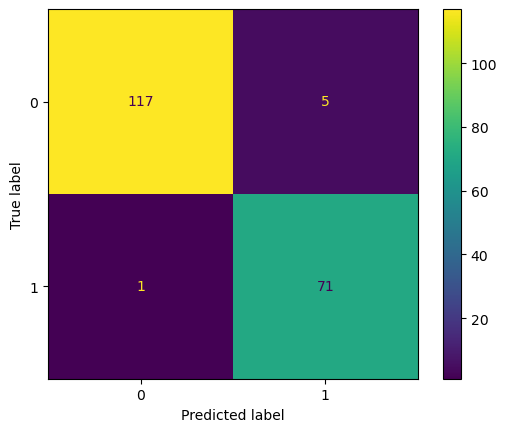

In [140]:
cm = confusion_matrix(y_test, y_pred)

n_classes = len(np.unique(y_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(n_classes))
disp.plot()

### As the Confusion Matrix suggests, our model labels correctly 71 out of 72 malignant tumor cells (True Positives), the Recall is therefore very satisfying and the F-1 score complements the general findings, for which we correclty predict 117 out of 122 benign tumor cells (True Negatives).